In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import sys
import os
import glob
import shutil
from tensorflow.keras.models import Sequential,load_model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import cv2
import tensorflow
from google.colab.patches import cv2_imshow
from PIL import Image
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from IPython.display import Image
!pip install utils
from utils import *

In [ ]:
def extract(img) : 
  kernel = np.ones((5,5))
  img2=img.copy()
  gray_img=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

  gray_img = cv2.adaptiveThreshold(gray_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
	                                     cv2.THRESH_BINARY_INV, blockSize = 321, C = 80)
  gray_img = cv2.GaussianBlur(gray_img, (3, 3), 0)
  gray_img = cv2.dilate(gray_img,kernel,iterations = 3)
  gray_img = cv2.erode(gray_img,kernel,iterations = 1)
  gray_image = cv2.morphologyEx(gray_img, cv2.MORPH_CLOSE, kernel)
  # gray_img=cv2.copyMakeBorder(gray_img,20,20,20,20,cv2.BORDER_CONSTANT)
  # cv2_imshow(gray_img)

  lst=[]
  for j in range(gray_image.shape[1]):
    sum = 0
    for i in range(gray_image.shape[0]):
      sum = sum+gray_image[i][j]
    lst.append(sum)
  # print(lst)
  rect = []
  f = 0
 
  for i in range(len(lst)):
    if lst[i] != 0 and f==0:
      x1=i
      f=1
    elif lst[i] == 0 and f==1:
      x2=i
      if(abs(x1-x2)>30):
        rect.append([min(x1,x2),max(x1,x2)])
      f=0 
  for k in range(len(rect)):
    x1=rect[k][0]
    x2=rect[k][1]
    lst2=[]
    for i in range(gray_image.shape[0]):
      sum=0
      for j in range(min(x1,x2),max(x1,x2)+1):
        sum = sum+gray_image[i][j]
      lst2.append(sum)
    # print(lst2)
    f=0
    for i in range(len(lst2)):
      if lst2[i] != 0 and f==0:
        y1=i
        f=1
      if lst2[i] == 0 and f==1:
        y2=i
        if(abs(y2-y1)>30):
          rect[k].append(min(y1,y2))
          rect[k].append(max(y1,y2))
        f=0 
  # print(rect)

  for i in range(len(rect)):
    if(len(rect[i])==4) :
      cv2.rectangle(img2,(rect[i][0],rect[i][2]),(rect[i][1],rect[i][3]),(0,255,0),3)
  cv2_imshow(img2)
  
  return gray_img, rect

In [ ]:
df = pd.read_csv('/content/emoji (1).csv')
df

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
0,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7430,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7431,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7432,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
df['0'].value_counts()

4    1092
3    1071
5    1071
1    1050
6    1050
2    1050
0    1050
Name: 0, dtype: int64

In [ ]:
df.sample(frac=1)

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,784
7360,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1174,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
896,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3028,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2311,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1116,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6775,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1742,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1356,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
x = df.drop(columns = ['0'])
y = df['0']
x = np.array(x).astype(float)
y = np.array(y).astype(float)
x = x.reshape(x.shape[0] , 28 , 28 , 1)

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x/255.0, y, test_size=0.20, random_state=42)

In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(filters=12, kernel_size=(5,5), strides=2, activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=18, kernel_size=(3,3) , strides=2, activation='relu'))
model.add(keras.layers.Dropout(.5))

model.add(keras.layers.Conv2D(filters=24, kernel_size=(2,2), activation='relu'))
model.add(keras.layers.Flatten())

model.add(keras.layers.Dense(units=150, activation='relu'))
model.add(keras.layers.Dense(units=7, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 12, 12, 12)        312       
                                                                 
 dropout_16 (Dropout)        (None, 12, 12, 12)        0         
                                                                 
 conv2d_25 (Conv2D)          (None, 5, 5, 18)          1962      
                                                                 
 dropout_17 (Dropout)        (None, 5, 5, 18)          0         
                                                                 
 conv2d_26 (Conv2D)          (None, 4, 4, 24)          1752      
                                                                 
 flatten_8 (Flatten)         (None, 384)               0         
                                                                 
 dense_16 (Dense)            (None, 150)              

In [ ]:
np.max(x_train)

1.0

In [ ]:
history = model.fit(x_train , y_train, epochs=30)

Epoch 1/30
186/186 [==============================] - 3s 10ms/step - loss: 1.3269 - accuracy: 0.4863
Epoch 2/30
186/186 [==============================] - 2s 11ms/step - loss: 0.8224 - accuracy: 0.7135
Epoch 3/30
186/186 [==============================] - 2s 12ms/step - loss: 0.6429 - accuracy: 0.7809
Epoch 4/30
186/186 [==============================] - 3s 17ms/step - loss: 0.5313 - accuracy: 0.8165
Epoch 5/30
186/186 [==============================] - 3s 15ms/step - loss: 0.4299 - accuracy: 0.8608
Epoch 6/30
186/186 [==============================] - 3s 16ms/step - loss: 0.3929 - accuracy: 0.8682
Epoch 7/30
186/186 [==============================] - 3s 17ms/step - loss: 0.3488 - accuracy: 0.8759
Epoch 8/30
186/186 [==============================] - 3s 18ms/step - loss: 0.3200 - accuracy: 0.8959
Epoch 9/30
186/186 [==============================] - 3s 18ms/step - loss: 0.2653 - accuracy: 0.9087
Epoch 10/30
186/186 [==============================] - 3s 16ms/step - loss: 0.2454 - accura

In [ ]:
model.evaluate(x_test , y_test)

47/47 [==============================] - 1s 3ms/step - loss: 0.0382 - accuracy: 0.9866


[0.03823666647076607, 0.9865500926971436]

In [ ]:
model.save('/content/drive/MyDrive/mosaic/model_emoji.h5')

In [ ]:
def predict(image):
    num_classes=26
    model_emoji = load_model('/content/drive/MyDrive/mosaic/model_emoji.h5')
    model = load_model('/content/drive/MyDrive/mosaic/model_full.h5')
    class_mapping='1234567ABDEFHJKLMNPRSTWXYZ'
    count=0
    total=0
    images, rect=extract(image)
    answer=""
    for i in range(len(rect)):
        # kernel = np.ones((3,3))
        if(len(rect[i])==4):
          image1=images[rect[i][2]:rect[i][3], rect[i][0]:rect[i][1]]
        else:
          continue
        image1=cv2.copyMakeBorder(image1,40,40,40,40,cv2.BORDER_CONSTANT)
        # image1 = cv2.morphologyEx(image1, cv2.MORPH_CLOSE, kernel)
        image1 = cv2.resize(image1, (28, 28))
        cv2_imshow(image1)
        image1 = (np.array(image1)).reshape(1 , 28 , 28 , 1)
        image1=image1/255

        result = np.argmax(model.predict(image1))
        result_confidence=np.max(model.predict(image1))

        result1 = np.argmax(model_emoji.predict(image1))
        result_confidence1=np.max(model_emoji.predict(image1))
        # print("model",class_mapping[result],result_confidence)
        if(result_confidence1-result_confidence>0.10 and result_confidence<0.75):
          print("model_emoji",class_mapping[result1],result_confidence1)
          answer+=(class_mapping[result1])
        else :
          print("model",class_mapping[result],result_confidence)
          answer+=(class_mapping[result])
    return answer

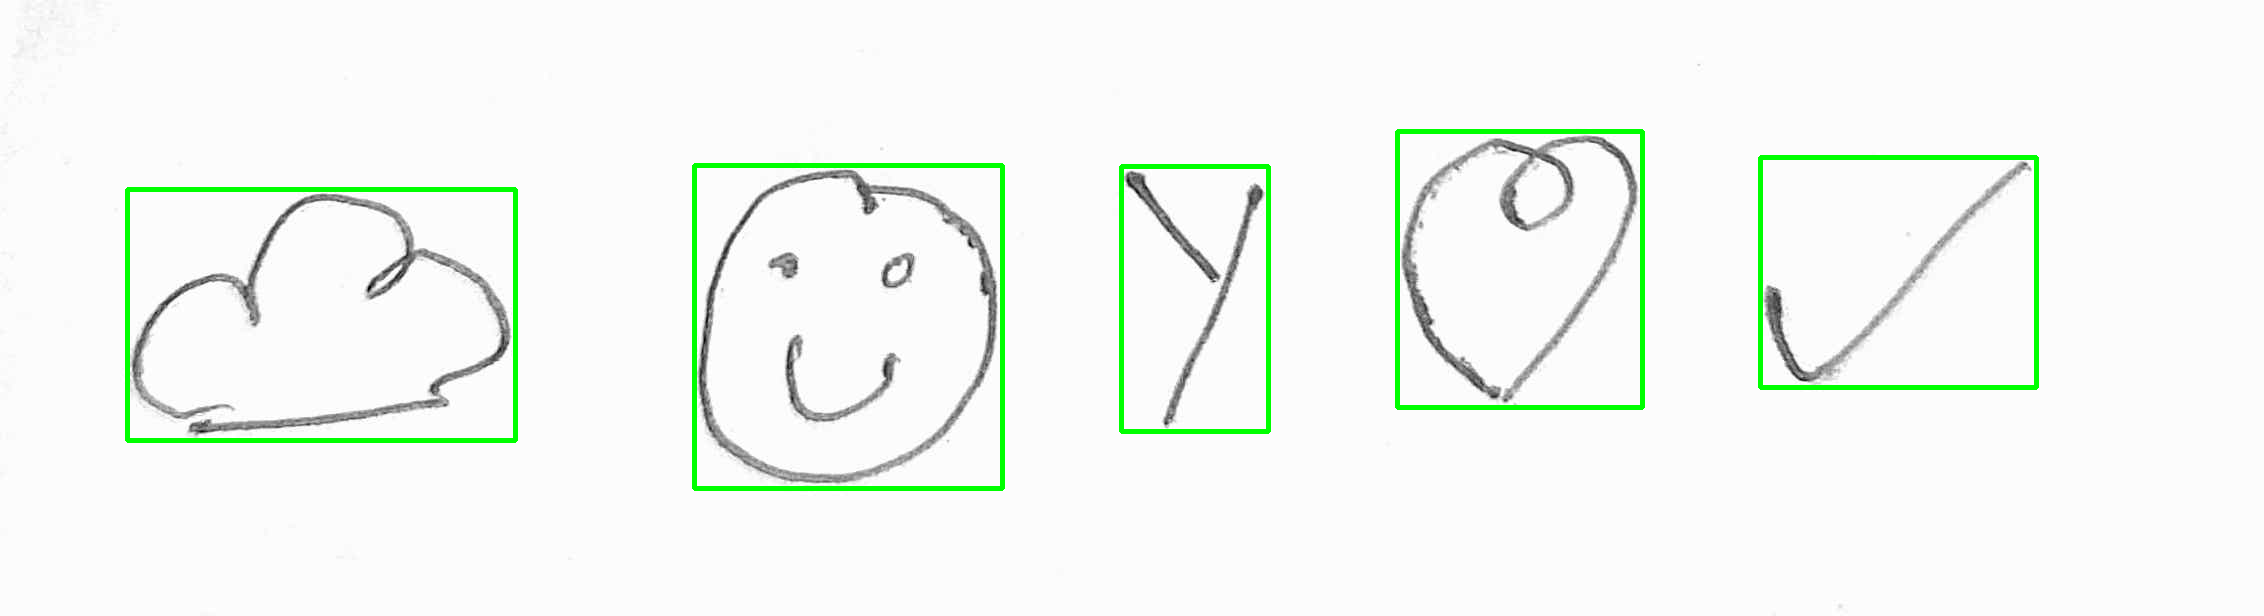

model 6 0.9992932


model 6 0.9994398


model Y 0.99994576


model 4 0.98554265


model 1 0.9886573


'66Y41'

In [ ]:
img = cv2.imread('/content/img10.jpeg')
predict(img)